In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib

In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [71]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

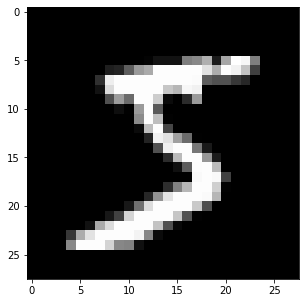

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim=28, latent_dim=10, hidden_dim=16):
        super(VAE, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels, 2 strides, same padding
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        # conv layer (depth from 32 --> 64), 3x3 kernels, 2 strides, same padding
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)        
        # linear layer (64 * 7 * 7 -> hidden_dim)
        self.fc1 = nn.Linear(64 * 7 * 7, hidden_dim)
        # add the z layers (hidden_dim -> latent_dim)
        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_log_var = nn.Linear(hidden_dim, latent_dim)
        
        ## decoder layers ##
        # linear layer (latent_dim -> 64 * 7 * 7)
        self.fc2 = nn.Linear(latent_dim, 64 * 7 * 7)
        self.t_conv1 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.t_conv3 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)


    def encode(self, x):
#         print('encoder shapes:')
        h = F.relu(self.conv1(x))
# #         print(h.shape)
        h = F.relu(self.conv2(h))
# #         print(h.shape)
        # Flatten
        h = h.view(-1, 64 * 7 *7)
# #         print(h.shape)
        # add the final encoding layer, with relu activation function
        h = F.relu(self.fc1(h))
# #         print(h.shape)
        return self.z_mu(h), self.z_log_var(h)
    
    
    def reparam(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, x):
#         print('decode shapes:')
        x = F.relu(self.fc2(x))
#         print(x.shape)
        x = x.view(-1, 64, 7, 7)
#         print(x.shape)
        x = F.relu(self.t_conv1(x))
#         print(x.shape)
        x = F.relu(self.t_conv2(x))
#         print(x.shape)
        return F.sigmoid(self.t_conv3(x))
        
        
        
    def forward(self, x):
        mu, log_var = self.encode(x)
#         print('z shapes:')
        z = self.reparam(mu, log_var)
#         print(z.shape)
        x = self.decode(z)
#         print(x.shape)
        return x, mu, log_var
    
# initialize the NN
model = VAE()
print(model)

VAE(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=16, bias=True)
  (z_mu): Linear(in_features=16, out_features=10, bias=True)
  (z_log_var): Linear(in_features=16, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3136, bias=True)
  (t_conv1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [50]:
class VAE(nn.Module):
    def __init__(self, data_dim=784, z_dim=2, hidden_dim=500):
        """
        VAE basic model.
        Args:
            data_dim (int): dimension of flatten input
            z_dim (int): dimension of manifold
            hidden_dim (int): dimension of hidden layers between input and manifold
        """
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(data_dim, hidden_dim)
        self.hidden2mu = nn.Linear(hidden_dim, z_dim)
        self.hidden2log_var = nn.Linear(hidden_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, data_dim)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.hidden2mu(h1), self.hidden2log_var(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def reparam(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparam(mu, log_var)
        return self.decode(z), mu, log_var


In [51]:
def loss_func(x_reconstructed, x, mu, log_var):
    """
    Loss function for VAE
    Args:
        x_reconstructed (torch.Tenor): decoder output [batch_size, input_size]
        x (torch.Tensor): input data [batch_size, input_size]
        mu (torch.Tensor): [batch_size, z_dim]
        log_var (torch.Tensor): [batch_size, z_dim]
    Returns (torch.Tensor): tensor of single loss value
    """
    # Reconstruction loss
    bce = F.binary_cross_entropy(x_reconstructed, x.view(-1, 28*28), reduction="sum")
    # KL divergence
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kld

In [52]:
def train(data_loader, model, loss_func, epoch):
    model.train()
    train_loss = 0
    for batch_i, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        # print(recon_batch.shape)
        loss = loss_func(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_i * len(data), len(data_loader.dataset),
                       100. * batch_i / len(data_loader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(data_loader.dataset)))

In [53]:
def test(data_loader, model, loss_func):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, log_var = model(data)
            test_loss += loss_func(recon_batch, data, mu, log_var).item()

    test_loss /= len(data_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [54]:
import torch.optim as optim
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters())

In [56]:
from torchvision.utils import save_image
epochs=25
for epoch in range(1, epochs+1):
    train(train_loader, model, loss_func, epoch)
    test(test_loader, model, loss_func)
    with torch.no_grad():
        sample = torch.randn(20, 2).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(20, 1, 28, 28), f'{epoch}.png', nrow=10)

Train Epoch: 1 [0/60000 (0%)]	Loss: 147.139429
Train Epoch: 1 [1000/60000 (2%)]	Loss: 152.730713
Train Epoch: 1 [2000/60000 (3%)]	Loss: 176.174817
Train Epoch: 1 [3000/60000 (5%)]	Loss: 166.905664
Train Epoch: 1 [4000/60000 (7%)]	Loss: 146.490759
Train Epoch: 1 [5000/60000 (8%)]	Loss: 162.009839
Train Epoch: 1 [6000/60000 (10%)]	Loss: 167.831555
Train Epoch: 1 [7000/60000 (12%)]	Loss: 165.366968
Train Epoch: 1 [8000/60000 (13%)]	Loss: 192.584204
Train Epoch: 1 [9000/60000 (15%)]	Loss: 158.136804
Train Epoch: 1 [10000/60000 (17%)]	Loss: 166.183118
Train Epoch: 1 [11000/60000 (18%)]	Loss: 164.536548
Train Epoch: 1 [12000/60000 (20%)]	Loss: 167.828943
Train Epoch: 1 [13000/60000 (22%)]	Loss: 160.630347
Train Epoch: 1 [14000/60000 (23%)]	Loss: 150.015234
Train Epoch: 1 [15000/60000 (25%)]	Loss: 155.396924
Train Epoch: 1 [16000/60000 (27%)]	Loss: 154.208167
Train Epoch: 1 [17000/60000 (28%)]	Loss: 166.915332
Train Epoch: 1 [18000/60000 (30%)]	Loss: 151.836816
Train Epoch: 1 [19000/60000 (32

In [75]:
plot_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=num_workers)
model.eval()
test_loss = 0
MUs = np.zeros((10000,2))
labels = []
with torch.no_grad():
    for i, (data, label) in enumerate(plot_loader):
        data = data.to(device)
        _, mu, _ = model(data)
        # print(i)
        MUs[i] = (mu.cpu())
        labels.append(label)

test_loss /= len(plot_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: 0.0000


In [76]:
len(MUs)

10000

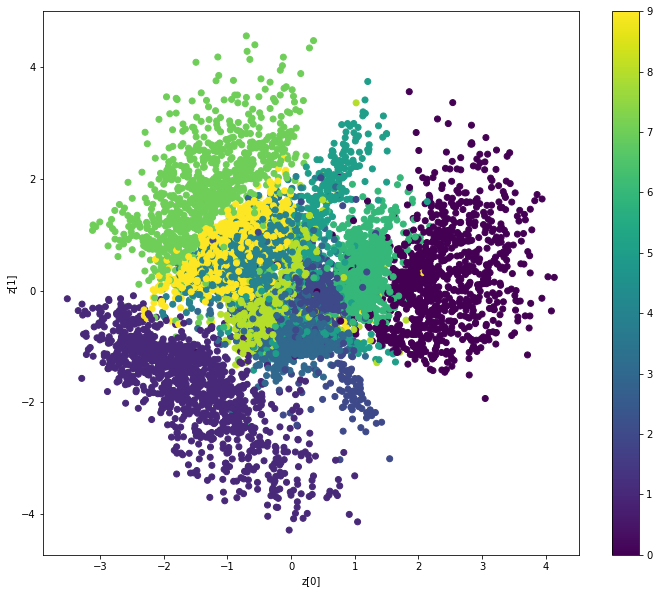

In [77]:
plt.figure(figsize=(12, 10))
plt.scatter(MUs[:, 0], MUs[:, 1], c=labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [ ]:
def plot_label_clusters(labels):
    # display a 2D plot of the digit classes in the latent space
    _, z_mean, _ = moodel(data_loader)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)